In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# prompt: clone this github repository : fivethirtyeight/russian-troll-tweets

!git clone https://github.com/fivethirtyeight/russian-troll-tweets.git


Cloning into 'russian-troll-tweets'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (80/80), 476.17 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (14/14), done.


# Reading all CSV files

In [ ]:
# List of CSV files
csv_files = [
    "IRAhandle_tweets_1.csv", "IRAhandle_tweets_2.csv",
    "IRAhandle_tweets_3.csv", "IRAhandle_tweets_4.csv",
    "IRAhandle_tweets_5.csv", "IRAhandle_tweets_6.csv",
    "IRAhandle_tweets_7.csv", "IRAhandle_tweets_8.csv",
    "IRAhandle_tweets_9.csv", "IRAhandle_tweets_10.csv",
    "IRAhandle_tweets_11.csv", "IRAhandle_tweets_12.csv",
    "IRAhandle_tweets_13.csv"
]

# Create an empty DataFrame to store the data
df = pd.DataFrame()

# Iterate through CSV files and append them to the DataFrame
for csv_file in csv_files:
    dfread = pd.read_csv('/content/russian-troll-tweets/'+ csv_file, low_memory=False)
    dfread= dfread[dfread.language == 'English']
    df = pd.concat([df, dfread], ignore_index=True)

# Cleaning content of the tweet

In [ ]:
def text_cleaning(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r"http\S+", "", text)
        # Remove mentions
        text = re.sub(r"@\S+", "", text)
        # Convert text to lowercase
        text = text.lower()
        # Remove punctuation and non-alphabetic characters
        text = re.sub(r"[^a-zA-Z ]+", "", text)
        return text
    else:
        return str(text)


In [ ]:
df['Cleaned_Text'] = df['content'].apply(lambda text: text_cleaning(text) if text_cleaning(text) is not None else text)

In [ ]:
# Download stopwords data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Initialize a set with stopwords for all languages
stop_words = stopwords.words('english')

In [ ]:
# Tokenize the text
tokenized_text = [word_tokenize(text) for text in df.Cleaned_Text]


# Remove stop words
stemmer = PorterStemmer()
cleaned_text = [[stemmer.stem(word) for word in text if word not in stop_words] for text in tokenized_text]


In [ ]:
# Create the Word2Vec model
model = Word2Vec(cleaned_text, min_count=10)

# Save the model
model.save('word2vec_min10.model')

NameError: ignored

In [ ]:
model = Word2Vec.load('word2vec_min10.model')
embeddings = model.wv.vectors

In [ ]:
male_words= ['he',
 'man',
 'boy',
 'brother',
 'husband',
 'father',
 'son',
 'groom',
 'king']

female_words= ['she',
 'woman',
 'girl',
 'sister',
 'wife',
 'mother',
 'daughter',
 'bride',
 'queen']

In [ ]:
male_vector = np.array([model.wv[word] for word in male_words])
female_vector = np.array([model.wv[word] for word in female_words])

In [ ]:
words = list(model.wv.key_to_index.keys())

In [ ]:
political_words = ['populist',
 'authoritarian',
 'nationalist',
 'socialist',
 'capitalist',
 'anarchist',
 'green',
 'pacifist',
 'nationalist',
 'feminist',
 'secular',
 'lobbyist',
 'partisan',
 'centrist']


political_positions = ['president',
 'governor',
 'mayor',
 'chancellor',
 'consul',
 'member',
 'chief',
 'attorney',
 'advisor',
 'analyst',
 'lobbyist',
 'diplomat',
 'ombudsman',
 'clerk']


political_viewpoints = [
 'authoritarian',
 'globalist',
 'capitalist',
 'hawkish',]

# Create a list of opposite viewpoints
opposite_viewpoints = [
 'libertarian',
 'nationalist',
 'socialist',
 'pacifist']

In [ ]:
# prompt: i want to calculate the mean distance of each word in political positions to male vector and female wector .

political_vector = np.array([model.wv[word] for word in political_positions])

from scipy.spatial.distance import cdist
mean_distance_male = np.mean(cdist(political_vector, male_vector,metric='cosine'), axis=1)
mean_distance_female = np.mean(cdist(political_vector, female_vector,metric='cosine'), axis=1)
# mean_distance_male = np.mean(np.linalg.norm(political_vector - male_vector, axis=1))
# mean_distance_female = np.mean(np.linalg.norm(political_vector - female_vector, axis=1))
print("Mean distance to male vector:", mean_distance_male)
print("Mean distance to female vector:", mean_distance_female)


Mean distance to male vector: [1.03963277 0.96063072 0.94349177 1.0481228  1.00542389 0.83762447
 0.90857566 0.91927288 1.01885678 1.0581408  1.02836261 0.90267529
 1.03455694 0.8522509 ]
Mean distance to female vector: [0.99056897 0.98292398 0.90982147 1.05036933 1.00272861 0.90099763
 0.99840891 0.93422688 1.13761578 1.16404939 1.06502304 0.93461068
 0.99800024 0.78247121]


In [ ]:
distance = dict()
for i,pos in enumerate(political_positions):
  distance[pos] = np.vstack((model.wv.cosine_similarities(political_vector[i],male_vector),
                             model.wv.cosine_similarities(political_vector[i],female_vector)))

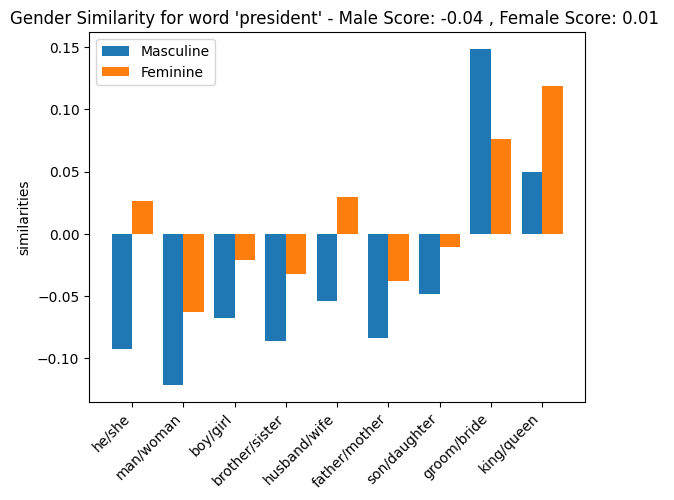

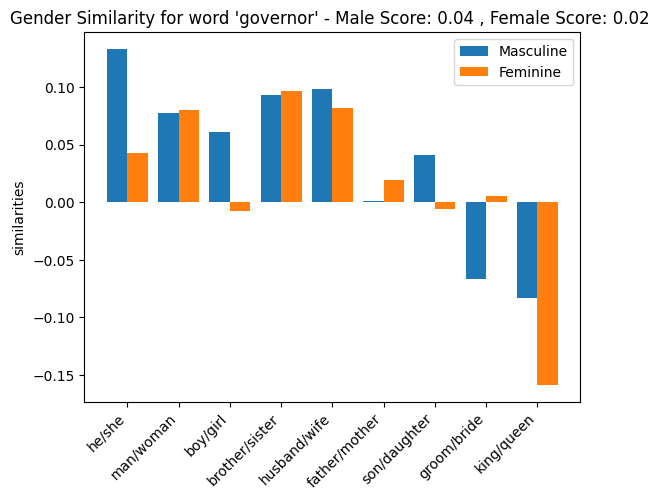

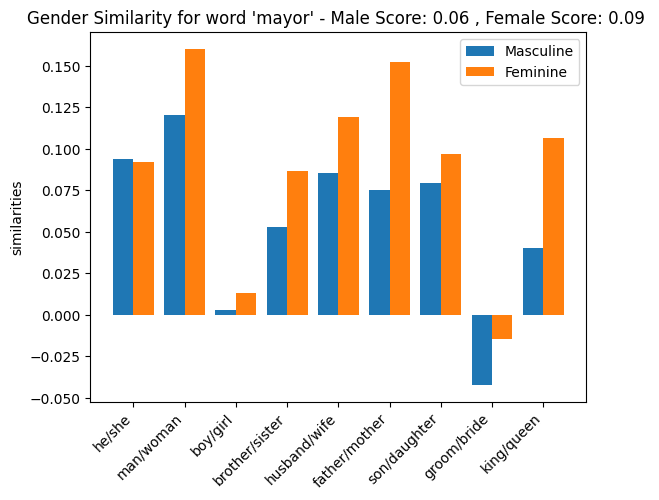

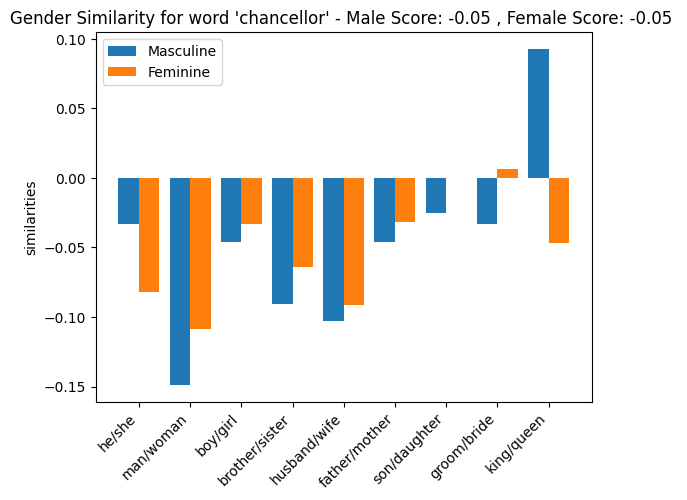

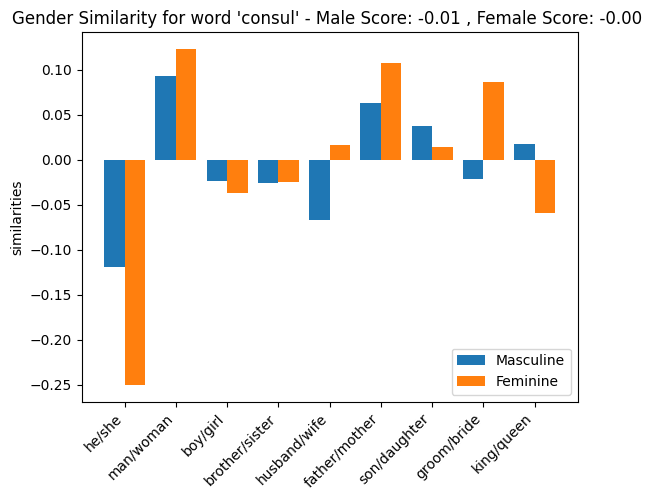

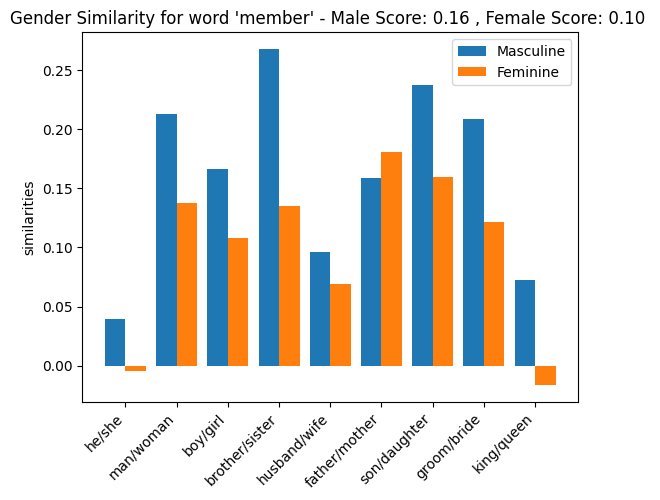

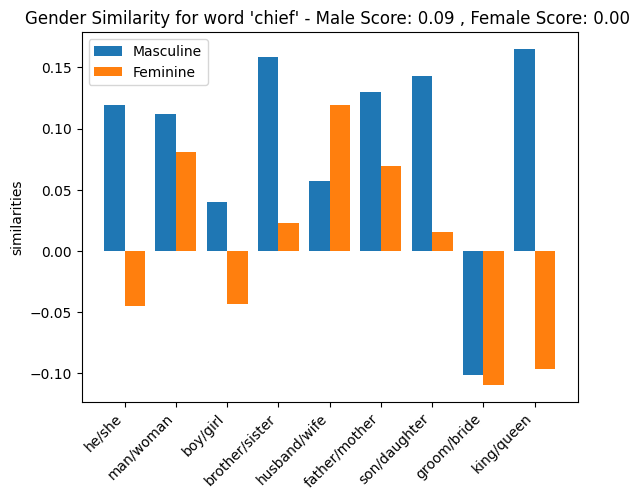

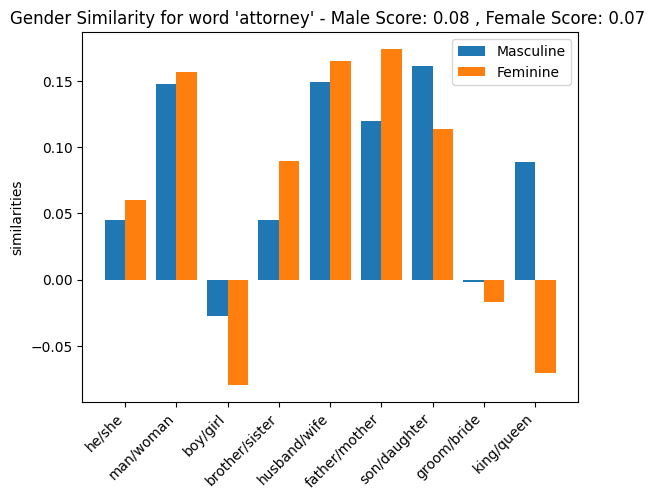

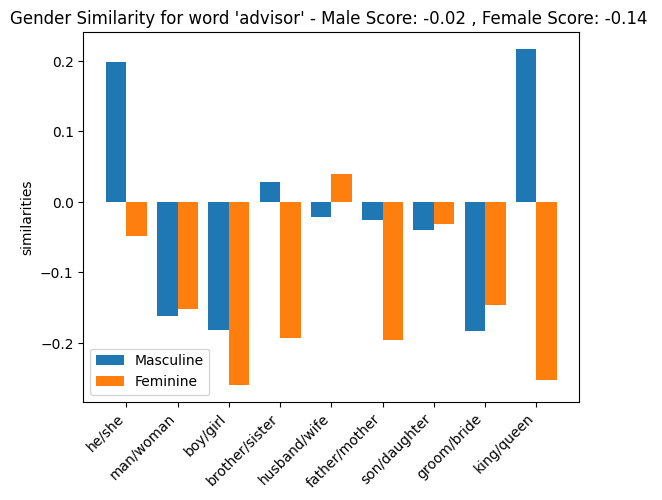

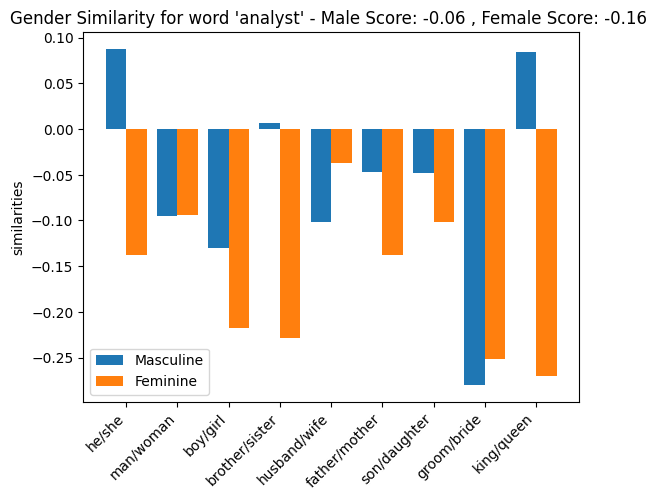

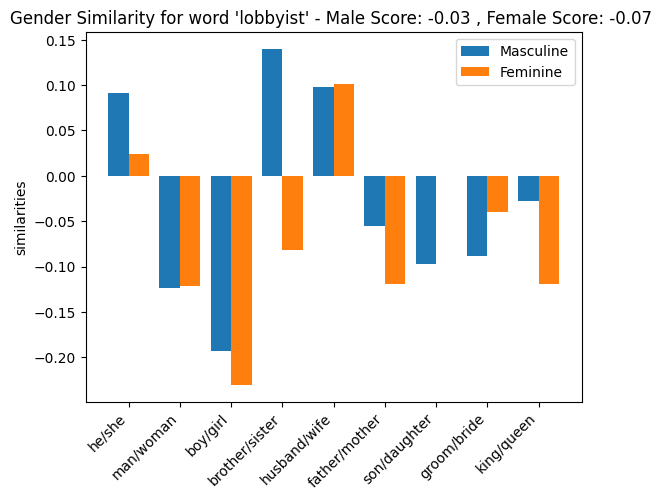

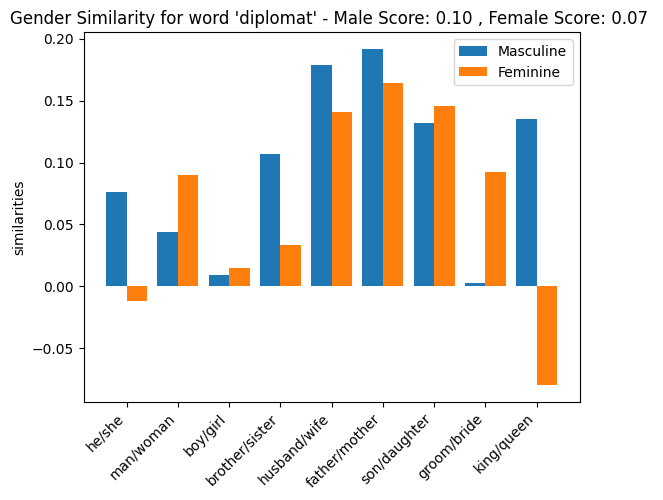

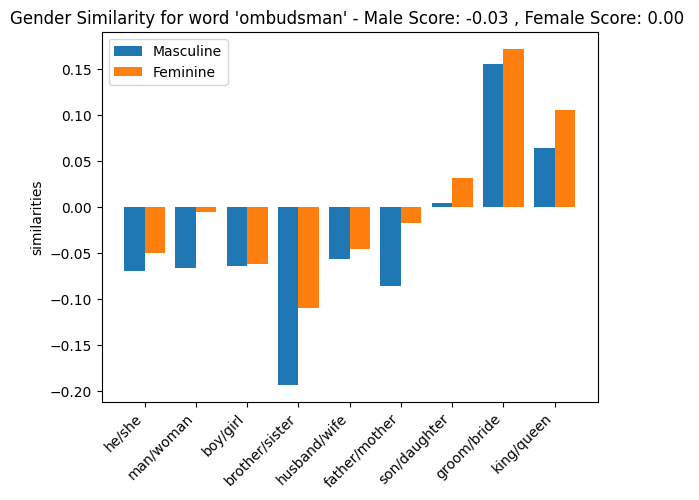

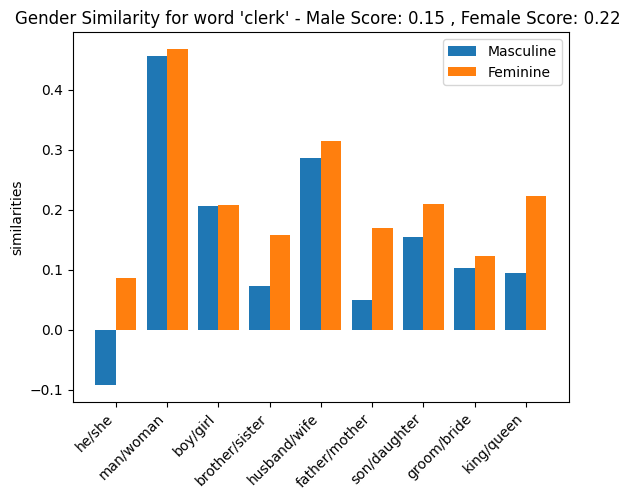

In [ ]:
for political_pos in political_positions:
  positions = np.arange(len(male_words))
  plt.bar(positions - 0.2, distance[political_pos][0], width=0.4, label='Masculine')
  plt.bar(positions + 0.2, distance[political_pos][1], width=0.4, label='Feminine')

  labels = [f'{x}/{y}' for x,y in zip(male_words,female_words)]
  plt.xlabel('')
  plt.ylabel('similarities')
  plt.title(f"Gender Similarity for word '{political_pos}' - Male Score: {distance[political_pos][0].mean():.2f} , Female Score: {distance[political_pos][1].mean():.2f} ")
  plt.xticks(positions, labels, rotation=45, ha='right')
  plt.legend()
  plt.show()

In [ ]:
# Select a subset of the embeddings
subset_embeddings = np.array([model.wv[word] for word in political_positions+male_words+female_words])

# Perform spectral clustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = spectral_clustering.fit_predict(subset_embeddings)

# Get the cluster labels
cluster_labels = spectral_clustering.labels_

# Visualize the clusters
tsne = TSNE(n_components=2,perplexity=7)
tsne_embeddings = tsne.fit_transform(subset_embeddings)

plt.figure(figsize = (15,10))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.title('Spectral Clustering of Word Embeddings')
# Annotate points with words
for i, word in enumerate(political_positions+male_words+female_words):
    plt.annotate(word, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))

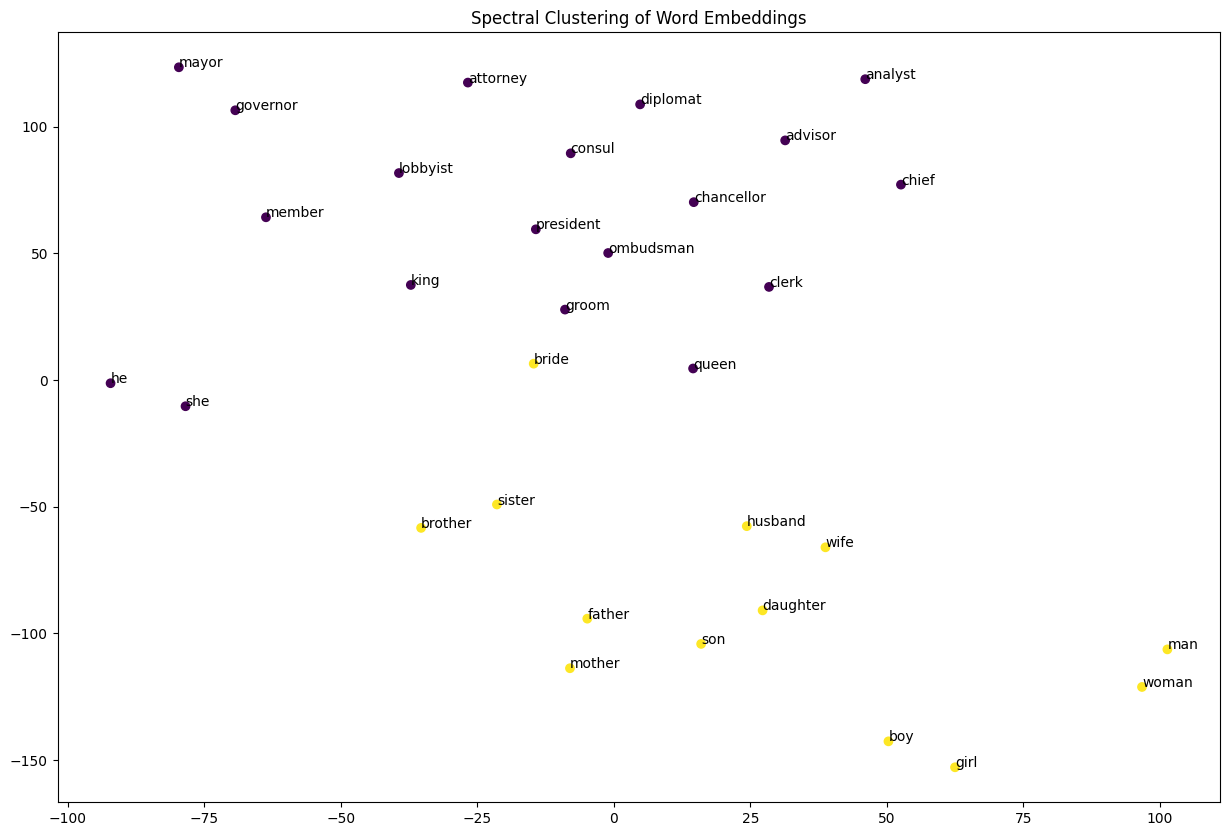

In [ ]:
# Visualize the clusters
tsne = TSNE(n_components=2,perplexity=7)
tsne_embeddings = tsne.fit_transform(subset_embeddings)

plt.figure(figsize = (15,10))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.title('Spectral Clustering of Word Embeddings')
# Annotate points with words
for i, word in enumerate(political_positions+male_words+female_words):
    plt.annotate(word, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))


plt.show()



In [ ]:
# prompt: clone from this link  https://github.com/mmihaltz/word2vec-GoogleNews-vectors.git

!git clone https://github.com/mmihaltz/word2vec-GoogleNews-vectors.git


fatal: destination path 'word2vec-GoogleNews-vectors' already exists and is not an empty directory.


In [ ]:
# prompt: I want to load google new model from nltk word2vec


# Download stopwords data
nltk.download('stopwords')
nltk.download('punkt')
# Load the Google News model
model = Word2Vec.load('GoogleNews-vectors-negative300.bin')
# Print the shape of the embeddings matrix
print(model.wv.vectors.shape)
# Get the word vectors for a given word
word = 'president'
print(model.wv[word])
# Find the most similar words to a given word
similar_words = model.wv.most_similar(word)
print(similar_words)
# Calculate the cosine similarity between two words
word1 = 'president'
word2 = 'he'
similarity = model.wv.cosine_similarity(word1, word2)
print(similarity)
# Generate a list of words from a given text
text = 'This is a test sentence.'
words = word_tokenize(text)
# Get the word vectors for each word in the list
word_vectors = [model.wv[word] for word in words]
# Calculate the average word vector for the text
average_word_vector = np.mean(word_vectors, axis=0)
# Find the most similar words to the average word vector
similar_words = model.wv.most_similar(average_word_vector)
print(similar_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO:gensim.utils:loading Word2Vec object from GoogleNews-vectors-negative300.bin


FileNotFoundError: ignored

In [ ]:
# prompt: use google news model

from gensim.models import Word2Vec
model = Word2Vec.load('GoogleNews-vectors-negative300.bin')
